# Credit Rating Prediction. Regression

Main goal of this lab is using some regression models and statistical methods for predicting right credit rating for any individual. If it is possible we'll try to interpretate model results. 

Dataset was found [here](https://www.kaggle.com/datasets/conorsully1/credit-score) on Kaggle platform.

## About the data

The dataset comprises information on 1000 customers, with 84 features derived from their financial transactions and current financial standing. The primary objective is to leverage this dataset for credit risk estimation and predicting potential defaults.

Our target variable:

- **CREDIT_SCORE: Numerical target variable representing the customer's credit score (integer)** 

Description of numerical features:

- INCOME: Total income in the last 12 months
- SAVINGS: Total savings in the last 12 months
- DEBT: Total existing debt
- R_SAVINGS_INCOME: Ratio of savings to income
- R_DEBT_INCOME: Ratio of debt to income
- R_DEBT_SAVINGS: Ratio of debt to savings

Transaction groups (GROCERIES, CLOTHING, HOUSING, EDUCATION, HEALTH, TRAVEL, ENTERTAINMENT, GAMBLING, UTILITIES, TAX, FINES) are categorized.

- T_[GROUP]: Total expenditure in that group in the last 6 months
- T_[GROUP]_12: Total expenditure in that group in the last 12 months
- R_[GROUP]: Ratio of T_[GROUP]6 to T[GROUP]_12
- R_[GROUP]_INCOME: Ratio of T[GROUP]_12 to INCOME
- R_[GROUP]_SAVINGS: Ratio of T[GROUP]_12 to SAVINGS
- R_[GROUP]_DEBT: Ratio of T[GROUP]_12 to DEBT

Categorical features:

- CAT_GAMBLING: Gambling category (none, low, high)
- CAT_DEBT: 1 if the customer has debt; 0 otherwise
- CAT_CREDIT_CARD: 1 if the customer has a credit card; 0 otherwise
- CAT_MORTGAGE: 1 if the customer has a mortgage; 0 otherwise
- CAT_SAVINGS_ACCOUNT: 1 if the customer has a savings account; 0 otherwise
- CAT_DEPENDENTS: 1 if the customer has any dependents; 0 otherwise

## Objectives

Here are the following steps that we need to complete during this work:
1. Finding out relationships between features and tagret
2. Testing some hypothesis about the credit score of various groups of people
3. Reducing number of features with `PCA`.
4. Building `Ridge`, `LASSO` and `ElasticNet` models
5. Adjusting them with Cross Validation and `GridSearchCV`
6. Defining most valuable features
7. Selecting and testing the best model

***

## Installing Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import normaltest
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA

sns.set_theme()

## Loading and Cleaning the Data

We're going to read a `.csv` file into *pandas* DataFrame and look at first 5 rows:

In [3]:
data = pd.read_csv('credit_score.csv')
data.head()

CUST_ID  INCOME  SAVINGS     DEBT  R_SAVINGS_INCOME  R_DEBT_INCOME  \
0  C02COQEVYU   33269        0   532304            0.0000        16.0000   
1  C02OZKC0ZF   77158    91187   315648            1.1818         4.0909   
2  C03FHP2D0A   30917    21642   534864            0.7000        17.3000   
3  C03PVPPHOY   80657    64526   629125            0.8000         7.8000   
4  C04J69MUX0  149971  1172498  2399531            7.8182        16.0000   

   R_DEBT_SAVINGS  T_CLOTHING_12  T_CLOTHING_6  R_CLOTHING  ...  \
0          1.2000           1889           945      0.5003  ...   
1          3.4615           5818           111      0.0191  ...   
2         24.7142           1157           860      0.7433  ...   
3          9.7499           6857          3686      0.5376  ...   
4          2.0465           1978           322      0.1628  ...   

   R_EXPENDITURE_SAVINGS  R_EXPENDITURE_DEBT  CAT_GAMBLING  CAT_DEBT  \
0                 0.0000              0.0625          High         1   
1                 0.7692              0.2222            No         1   
2                 1.4286              0.0578          High         1   
3                 1.2500              0.1282          High         1   
4                 0.1163              0.0568          High         1   

   CAT_CREDIT_CARD  CAT_MORTGAGE  CAT_SAVINGS_ACCOUNT  CAT_DEPENDENTS  \
0                0             0                    0               0   
1                0             0                    1               0   
2                0             0                    1               0   
3                0             0                    1               0   
4                1             1                    1               1   

   CREDIT_SCORE  DEFAULT  
0           444        1  
1           625        0  
2           469        1  
3           559        0  
4           473        0  

[5 rows x 87 columns]

Let's look data for duplicates and missing values:

In [4]:
print('Checking for unique values:', data['CUST_ID'].is_unique)
print('Num of missing values:', data.isna().sum().sum())

Checking for unique values: True
Num of missing values: 0


*CUST_ID* column just became useless for us so we delete him.

In [5]:
#eliminating CUST_ID column
data.drop('CUST_ID', axis=1, inplace=True)

In [6]:
data.columns = data.columns.str.lower()

cat_cols = [x for x in data.columns if 'cat_' in x] + ['default']
num_cols = [ 'credit_score',
             'income',
             'savings',
             'debt',
             'r_savings_income',
             'r_debt_income',
             'r_debt_savings']
groups_cols = [x for x in data.columns if (x not in num_cols) and (x not in cat_cols)]

#check if we missed any columns
len(cat_cols) + len(num_cols) + len(groups_cols) == len(data.columns)

True

We just splitted columns into 3 groups. That may help us further in a standard scaling part.

Finally let's take a general info about our columns:

**Categorical columns**

In [7]:
data[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   cat_gambling         1000 non-null   object
 1   cat_debt             1000 non-null   int64 
 2   cat_credit_card      1000 non-null   int64 
 3   cat_mortgage         1000 non-null   int64 
 4   cat_savings_account  1000 non-null   int64 
 5   cat_dependents       1000 non-null   int64 
 6   default              1000 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 54.8+ KB


*Gambling* has object type. This column probably has ordinal values. We should encode him

In [8]:
data['cat_gambling'].unique()

array(['High', 'No', 'Low'], dtype=object)

In [9]:
encode_dict = {'High': 2, 'Low': 1, 'No': 0}

data['cat_gambling'].replace(encode_dict, inplace=True)
data['cat_gambling'].unique()

array([2, 0, 1], dtype=int64)

Done✅

**Numerical columns**

In [10]:
data[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      1000 non-null   int64  
 1   income            1000 non-null   int64  
 2   savings           1000 non-null   int64  
 3   debt              1000 non-null   int64  
 4   r_savings_income  1000 non-null   float64
 5   r_debt_income     1000 non-null   float64
 6   r_debt_savings    1000 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 54.8 KB


No problems here✅

**Transaction Groups columns**

In [11]:
data[groups_cols].dtypes.value_counts()

float64    48
int64      24
dtype: int64

No problems here✅

## Correlations and relationships. Numerical Columns

Now we're going to check our columns for correlations between each other. Finding out how features affect the credit rate may help us in feature selection. We'll be satisfied with the values that are greater than 0.4. 

Firstly we build a heatmap of correlations of our numerical columns:

<AxesSubplot:title={'center':'Pearson Correlation Heatmap'}>

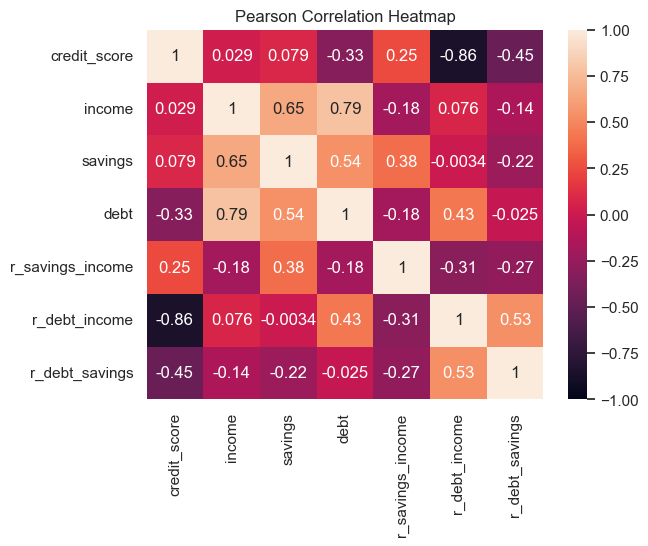

In [12]:
corrs = data[num_cols].corr()

plt.title("Pearson Correlation Heatmap")
sns.heatmap(corrs, annot=True, vmin=-1)

According to graph above, we can adopt some conclusions:
- We have strong feature for our target - **r_debt_income** that may lead our linear model to overfitting. Definitely we have to try regularization to avoid this problem
- In some reason, **debt** is highly correlated with **income**. **Savings** strongly correlated with **income** for obvious reasons. So correlation may lead to coefficients instability

Now, we're going to perform regression analysis to find multicollinearity. We're gonna fit linear model with our numerical features and predict each of these features. Then we're estimating $R^2$ and if estimated value is more then ~0.9 then predicted variable is being well-explained by other variables.


In [13]:
def r2_for_each_X(columns):
    LR = LinearRegression()
    scores = []
    
    for col in columns:
        X = [x for x in columns if x != col]
        y = col
        predictions = cross_val_predict(LR, data[X], data[y], cv=3)
        r2 = r2_score(data[y], predictions)
        scores.append(r2)

    sns.barplot(x=columns, y=scores)
    plt.title('$R^2$ for predicted X')
    plt.xticks(rotation=30)
    plt.ylabel('$R^2$')
    plt.xlabel('Features')
    plt.show()

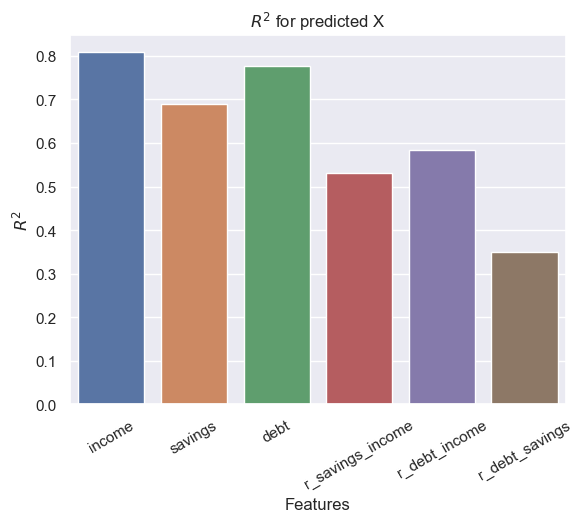

In [14]:
columns = [x for x in num_cols if x != 'credit_score']
r2_for_each_X(columns)

The graph above means that **Income** and **Debt** variables can be more easily linear predicted. On the other hand we have variance inflaction factor which estimates as:

$$VIF = \frac{1}{(1-R^2)}$$

Value more than 4 may indicate multicollinearity. In this way $R^2 = 0.75$. We have reasons enough to prove multicollinearity. We can drop **income** column and check results again.

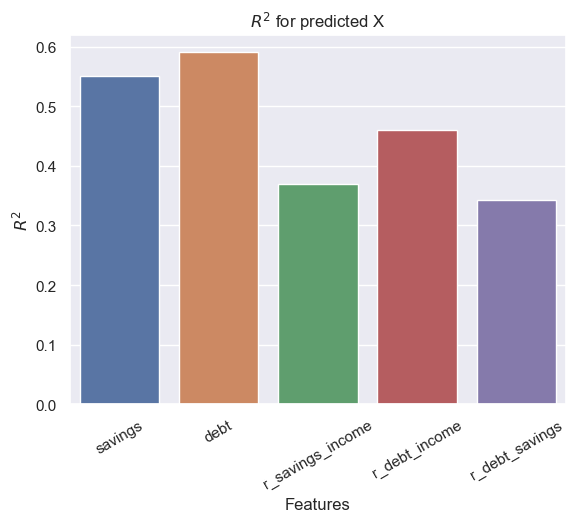

In [15]:
columns = [x for x in num_cols if x not in ['credit_score', 'income']]
r2_for_each_X(columns)

After deleting **income** variable, each of the other variables have lower $R^2$ now. I guess we should drop income column to avoid coefficients instability. Moreover income column doesn't affect the credit score unlike the debt column.

Now let's look at how these columns affect the credit score. We will plot scatter graphs with the construction of a curve estimated with polynomial regression.

In [16]:
selected_column = 'credit_score'
columns = [x for x in num_cols if x != selected_column]

fig = make_subplots(cols=1, rows=len(columns))

for i, column in enumerate(columns):
    #Fitting polynomial regression to plot a curve on a graph
    estimator = Pipeline([('pf', PolynomialFeatures(3)),
                         ('lr', LinearRegression())])
    
    estimator.fit(data[[column]], data[selected_column])
    x = np.linspace(data[column].min(), data[column].max(), 100)
    yp = estimator.predict(x.reshape(-1,1))
    
    #Plotting a graphs with Plotly
    #Scatter
    fig.add_trace(
        go.Scatter(y=data[selected_column], x=data[column], 
                   mode='markers', showlegend=False),
        row=i+1, col=1)
    
    #Line
    fig.add_trace(
        go.Scatter(y=yp, x=x, showlegend=False),
        row=i+1, col=1)
    
    #Naming axes
    fig.update_xaxes(title_text=column.title(), row=i+1, col=1)
    fig.update_yaxes(title_text=selected_column.title(), row=i+1, col=1)

fig.update_layout(height=1500, width=800, title_text='Scatterplots with Polynomial Regression Model')
fig.show()

<b><p style='color: red'>PLOTLY CAN'T BE DISPLAYED ON GITHUB JUPITER, SO HERE'S .png IMAGE OF THE GRAPH</p></b>

<img src='https://github.com/ssensse/ds_labs/blob/main/CreditScore_Regression/PlotlyGraphs/creditScore_vs_columns_scatter_polynomial.png?raw=true'>

Also we have Savings column which doesn't affect the credit score according to the heatmap and the plotly graph above. It has strong correlation with Income column, furthermore it's well-eplained linearly with other variables according to some graphs above. I guess **we should drop both income and savings columns** to avoid variance in our predictions.

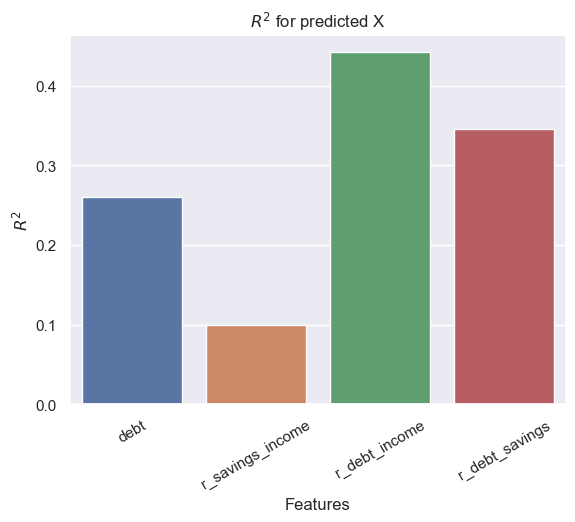

In [17]:
columns = [x for x in num_cols if x not in ['credit_score', 'income', 'savings']]
r2_for_each_X(columns)

## Hypothesis testing. Categorical Columns

In this section we're going to find out relationships between some categorical columns and credit_score. Also we'll test the following below hypothesis:
1. Is there any statistically significant difference in a credit score depending on measure of gambling?
2. Is there any statistically significant difference in a credit score depending on debt?
3. ...

We have the following columns to work with:

In [18]:
data[cat_cols].describe().T

count   mean       std  min  25%  50%  75%  max
cat_gambling         1000.0  0.644  0.870645  0.0  0.0  0.0  2.0  2.0
cat_debt             1000.0  0.944  0.230037  0.0  1.0  1.0  1.0  1.0
cat_credit_card      1000.0  0.236  0.424835  0.0  0.0  0.0  0.0  1.0
cat_mortgage         1000.0  0.173  0.378437  0.0  0.0  0.0  0.0  1.0
cat_savings_account  1000.0  0.993  0.083414  0.0  1.0  1.0  1.0  1.0
cat_dependents       1000.0  0.150  0.357250  0.0  0.0  0.0  0.0  1.0
default              1000.0  0.284  0.451162  0.0  0.0  0.0  1.0  1.0

### Normal Distribution. Credit Score

Before we start testing we have to make sure that credit_score is normal distributed. Let's plot a distplot and use normaltest.

We're rejecting the null hypothesis. Distribution is not a normal. 
P_VALUE = 5.54196259437697e-38
Skew: -1.0053323005099593


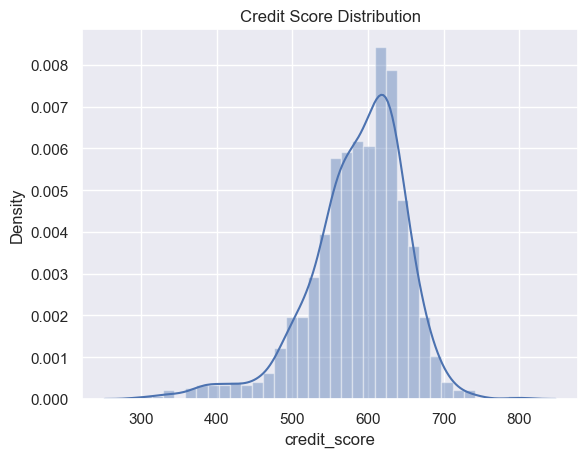

In [19]:
sns.distplot(data['credit_score'])
plt.title('Credit Score Distribution')

statistic, p_value = normaltest(data['credit_score'])
if p_value < 0.05:
    print("We're rejecting the null hypothesis. Distribution is not a normal. \nP_VALUE =", p_value)
else:
    print("We couldn't reject the null hypothesis. Distribution can be a normal. \nP_VALUE =", p_value)
print('Skew:', data['credit_score'].skew())

Our distrubtion isn't normal. Let's try to transform it with `boxcox`. 

We have the outlier in credit_score column. I tried to perform boxcox with this outlier included but the normality test showed low pvalue - *0.0005*. So we'll replace this outlier by mean and get normal distribution.

lambda: 3.543965863261878
Accept the null hypothesis. Distribution can be a normal. 
P_VALUE = 0.535790849754363
Skew: -0.008813204911741104


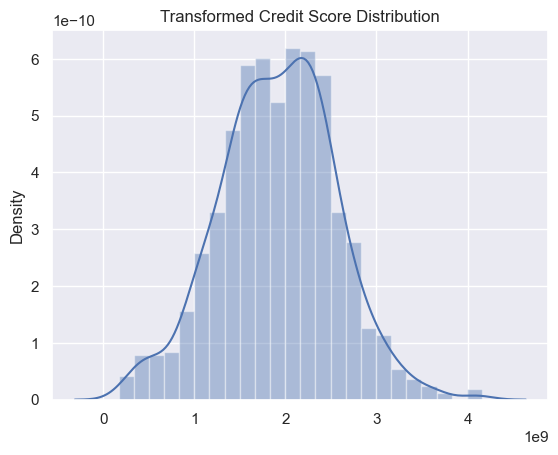

In [20]:
encode_dict = {800: data['credit_score'].mean()}
data['credit_score'] = data['credit_score'].replace(encode_dict)

credit_score_tr, lam = boxcox(data['credit_score'])
print('lambda:', lam)

sns.distplot(credit_score_tr)
plt.title('Transformed Credit Score Distribution')

statistic, p_value = normaltest(credit_score_tr)
if p_value < 0.05:
    print("Reject the null hypothesis. Distribution is not a normal. \nP_VALUE =", p_value)
else:
    print("Accept the null hypothesis. Distribution can be a normal. \nP_VALUE =", p_value)
print('Skew:', stats.skew(credit_score_tr))

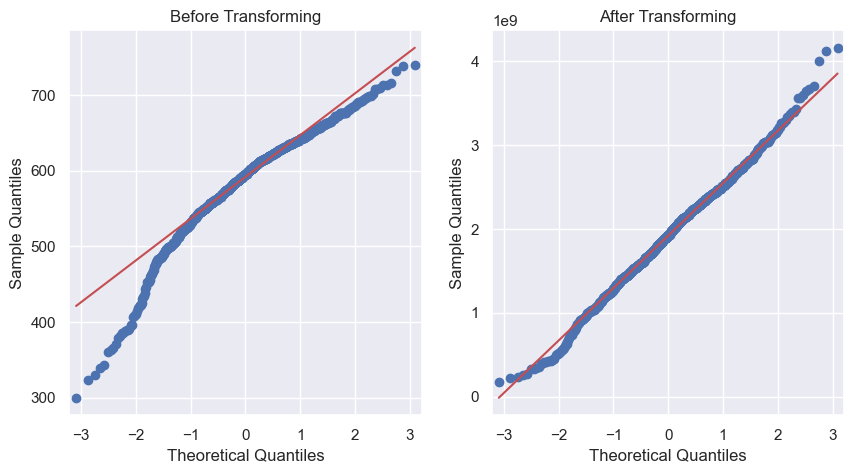

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

qqplot(data['credit_score'], line='q', ax=axs[0])
qqplot(credit_score_tr, line='q', ax=axs[1])
axs[0].set_title('Before Transforming')
axs[1].set_title('After Transforming')

plt.show()

We removed skewness of our data and approximated our data to a normal distribute as we could. 

### Relationship between Credit score and Gambling

We'll test the gambling column separately because it has 3 unique values. Firstly we're plotting a boxplot and histograms:

In [22]:
fig = px.histogram(x=credit_score_tr, color=data['cat_gambling'], marginal='box')
fig.update_xaxes(title_text='transformed credit score')
fig.update_layout(title_text='Transformed Credit score distributions by Gambling measure')
fig.show()

<b><p style='color: red'>PLOTLY CAN'T BE DISPLAYED ON GITHUB JUPITER, SO HERE'S .png IMAGE OF THE GRAPH</p></b>

<img src='https://github.com/ssensse/ds_labs/blob/main/CreditScore_Regression/PlotlyGraphs/creditScore_vs_gambling_hist.png?raw=true'>

If we look at the medians of boxplots we'll notice that high gambling has the most low median credit score. Now we're going to test this hypothesis with OLS model.

In [23]:
data_ols = pd.DataFrame({'credit_score': credit_score_tr, 
                         'cat_gambling': data['cat_gambling']})

In [24]:
model = ols('credit_score ~ C(cat_gambling)', data_ols).fit()
anova_lm(model)

df        sum_sq       mean_sq          F        PR(>F)
C(cat_gambling)    2.0  2.588827e+19  1.294413e+19  34.047257  4.972157e-15
Residual         997.0  3.790409e+20  3.801814e+17        NaN           NaN

We have p-value is much less than 0.05 so we have reasons to reject the null hypothesis. Null hypothesis means that there isn't any difference in credit score by measure of gambling. 

In regards to our graph above we also can see that credit score distribution of low gamblers seems the same as distribution of non-gamblers. We also can test this two distributions and probably get p_value more than 0.05. It's going to be usual `stats.ttest_ind`

In [25]:
model = ols('credit_score ~ C(cat_gambling)', data_ols.query('cat_gambling < 2')).fit()
anova_lm(model)

df        sum_sq       mean_sq         F    PR(>F)
C(cat_gambling)    1.0  7.396798e+16  7.396798e+16  0.181138  0.670522
Residual         734.0  2.997296e+20  4.083510e+17       NaN       NaN

In [26]:
# code for verification
# indexes1 = data.query('cat_gambling == 0').index
# indexes2 = data.query('cat_gambling == 1').index
# sample1 = credit_score_tr[indexes1]
# sample2 = credit_score_tr[indexes2]

# stats.ttest_ind(sample1, sample2).pvalue

#OUT: 0.6705216415526023

That's it. Non-gamblers has the same credit score distribution as low gamblers with a probability of 67%. So we can combine them into one group. Then all of our categorical columns are going to be binary.

In [27]:
data['cat_gambling'] = data['cat_gambling'].replace({1:0, 2:1})
data['cat_gambling'].value_counts()

0    736
1    264
Name: cat_gambling, dtype: int64

**Conclusions:** There's a difference in credit score by measure of gambling. High gamblers probably has lower credit score.

### Relationship between Credit score and Other categorical variables

We have other categorical variable like the following:
- Debt
- Credit Card
- Mortgage
- Savings account
- Dependents

Now let's look at histograms to find the differences visually:

In [28]:
excluded_cols = ['cat_gambling']
columns = [col for col in cat_cols if col not in excluded_cols]

fig = make_subplots(rows=len(columns), cols=2, column_widths=[0.7, 0.3])

for i, col in enumerate(columns):
    fig.add_trace(
        go.Box(x=credit_score_tr, y=data[col],
               orientation='h', showlegend=False, jitter=1),
        row=i+1, col=1)
    
    val_counts = data[col].value_counts()
    fig.add_trace(
        go.Bar(y=val_counts, x=val_counts.index, showlegend=False),
        row=i+1, col=2)
    
    fig.update_xaxes(title_text='Credit_Score', row=i+1, col=1)
    fig.update_yaxes(title_text=col.title(), row=i+1, col=1)
    
    fig.update_xaxes(title_text=col.title(), row=i+1, col=2)
    fig.update_yaxes(title_text='Count', row=i+1, col=2)

fig.update_layout(title_text='Transformed Credit Score Distribution by Categorical columns', height=1500, width=900)
fig.show()

<b><p style='color: red'>PLOTLY CAN'T BE DISPLAYED ON GITHUB JUPITER, SO HERE'S .png IMAGE OF THE GRAPH</p></b>

<img src='https://github.com/ssensse/ds_labs/blob/main/CreditScore_Regression/PlotlyGraphs/creditScore_vs_catColumns_box_bar.png?raw=true'>

Each of them are booleans, so we have pass them through a cycle and calculate pvalue for all of them. We'll exclude *cat_savings_account* column from testing because it's highly disbalanced.

Alternative hypothesis is going to be two-sided.

In [29]:
excluded_cols = ['cat_gambling', 'cat_savings_account']
columns = [col for col in cat_cols if col not in excluded_cols]

alpha = 0.05
for col in columns:    
    indexes1 = data[data[col] == 0]['credit_score'].index
    indexes2 = data[data[col] == 1]['credit_score'].index
    sample1 = credit_score_tr[indexes1]
    sample2 = credit_score_tr[indexes2]
    
    #comparing the variances if they have +- the same value
    equal_var = (np.var(sample1) / np.var(sample2) <= 1.25) and (np.var(sample1) / np.var(sample2) >= 0.8)
    pvalue = stats.ttest_ind(sample1, sample2, equal_var=equal_var).pvalue
    
    print(f'CREDIT SCORE BY {col.upper()}')
    print(f' 0: Variance1: {np.var(sample1)}, Mean1: {np.mean(sample1)}')
    print(f' 1: Variance2: {np.var(sample2)}, Mean2: {np.mean(sample2)}')
    print(' P_VALUE:', pvalue)
    if pvalue < alpha:
        print(f"Reject the null hypothesis. Probably there's a difference in credit score by {col}", '\n')
    else:
        print(f"Accept the null hypothesis. Probably there isn't any difference in credit score by {col}", '\n')

CREDIT SCORE BY CAT_DEBT
 0: Variance1: 1.8625754119893248e+17, Mean1: 2477920126.425365
 1: Variance2: 3.9794512964805984e+17, Mean2: 1880962852.6592267
 P_VALUE: 1.6778498660397073e-14
Reject the null hypothesis. Probably there's a difference in credit score by cat_debt 

CREDIT SCORE BY CAT_CREDIT_CARD
 0: Variance1: 3.9154612967155757e+17, Mean1: 2002434211.5563889
 1: Variance2: 3.4192600332203674e+17, Mean2: 1629375942.207838
 P_VALUE: 1.367857914303323e-15
Reject the null hypothesis. Probably there's a difference in credit score by cat_credit_card 

CREDIT SCORE BY CAT_MORTGAGE
 0: Variance1: 3.915844850449403e+17, Mean1: 1911842389.8530233
 1: Variance2: 4.6854149281283936e+17, Mean2: 1926582679.6628933
 P_VALUE: 0.7819869994062798
Accept the null hypothesis. Probably there isn't any difference in credit score by cat_mortgage 

CREDIT SCORE BY CAT_DEPENDENTS
 0: Variance1: 3.970367992559906e+17, Mean1: 1959792047.8736699
 1: Variance2: 3.717877287758285e+17, Mean2: 1657128128.6

Statictical test accepted the null hypothesis about credit score by mortgage. All other columns do affect the credit score probably.

**Conclusions:** 
- High level of gambling decreases credit score
- Cat_Savings_Account is highly disbalanced column if we look at the appropriate barplot, so we excluded it from training features
- According to t-tests we perfomed: debt, creditCard, dependents and default have an impact on credit croring. If they are equal to 1 (exist) then credit rating decreases on average.

### Transaction categorized groups

We have a lot of columns to analyse. They're splitted into groups and each group has one numerical column with total expenses. We're going to look at these columns in the heatmap of correlations, so we can find multicollinearity:

<AxesSubplot:title={'center':'Heatmap of correlations of Transaction groups'}>

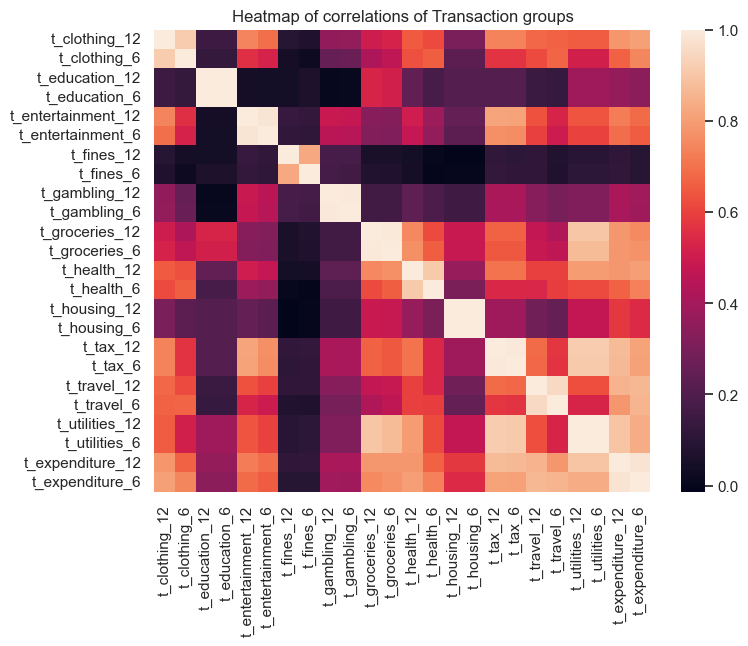

In [30]:
total_cols = [x for x in groups_cols if x[:2]=='t_']
corrs = data[total_cols].corr()
plt.figure(figsize=(8,6))
plt.title('Heatmap of correlations of Transaction groups')
sns.heatmap(corrs)

Well we have much of multicollinearity. At the next stage we'll try PCA to solve the problem of multicollinearity. Now we're going to look how these features affects the credit score.

In [31]:
corrs = [data[col].corr(data['credit_score']) for col in total_cols]
fig = px.bar(x=total_cols, y=corrs)
fig.update_layout(title_text='Correlations between Credit Score and Total expenses for each group')
fig.show()

<b><p style='color: red'>PLOTLY CAN'T BE DISPLAYED ON GITHUB JUPITER, SO HERE'S .png IMAGE OF THE GRAPH</p></b>

<img src='https://github.com/ssensse/ds_labs/blob/main/CreditScore_Regression/PlotlyGraphs/creditScore_vs_totalColumns_correlations.png?raw=true'>

## Linear Models. Regularization tuning

Since we are going to use regularization first of all we need to normalize our data. Categorical columns are already encoded. 

Let's split our data into train and test samples.

In [32]:
excluded_cols = ['credit_score', 'cat_mortgage', 'cat_savings_account']
X_train, X_test, y_train, y_test = train_test_split(data.drop(excluded_cols, axis=1),
                                                    data['credit_score'], 
                                                    test_size=0.25, 
                                                    random_state=582002)
print('Shape of train sample', X_train.shape)
print('Shape of test sample', X_test.shape)

Shape of train sample (750, 83)
Shape of test sample (250, 83)


Let's train 3 models:
1. Lasso
2. Ridge
3. ElasticNet

We're going use regularization so we need StandardScaler. To find best alpha for regularization we are using `GridSearchCV`. This function goes through the following steps:
1. StandardScaler
2. GridSearchCV
3. Cross validation predictions (based on train data)
4. Visualization of results

In [33]:
def fit_search_regressions(model, params, X, y):

    estimator = Pipeline([('ss', StandardScaler()),('model', model)])

    search = GridSearchCV(estimator, params, n_jobs=2, scoring='r2')
    search.fit(X, y)
    best = search.best_estimator_
    results = search.cv_results_
    weights = best['model'].coef_
    preds = cross_val_predict(best, X, y)
    r2 = search.best_score_
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    print('sum of coefficients:', np.abs(weights).sum())
    print('best_params:', search.best_params_)
    print('best_r2:', r2)
    print('RMSE:', rmse)
    print(best)
    
    sbplt_titles = ("Fitted Values VS Actual","R2 score by alpha with cross validation", "Coefficients of Features")
    fig = make_subplots(rows=2, cols=2,
                       specs=[[{}, {}],
                             [{"colspan": 2}, None]],
                       subplot_titles=sbplt_titles)

    fig.add_trace(
        go.Scatter(y=preds, x=y, mode='markers'),
        row=1, col=1)
    
    fig.add_trace(
        go.Scatter(y=y, x=y),
        row=1, col=1)

    fig.add_trace(
        go.Scatter(y=results['mean_test_score'], x=results['param_model__alpha']),
        row=1, col=2)

    fig.add_trace(
        go.Bar(x=X.columns, y=weights[abs(weights) > 0]),
        row=2,col=1)
    
    fig.update_yaxes(title_text='predictions', row=1, col=1)
    fig.update_xaxes(title_text='actual values', row=1, col=1)
    fig.update_yaxes(title_text='$R^2$', row=1, col=2)
    fig.update_xaxes(title_text='alphas', row=1, col=2)
    fig.update_yaxes(title_text='weights', row=2, col=1)
    
    fig.update_layout(height=800, width=900, xaxis2_type='log', showlegend=False)
    fig.show()
    
    return best, weights, r2, rmse

### 1. Lasso Regression

In [34]:
alphas = np.geomspace(1e-6, 5, 40)
params = {'model__alpha': alphas}
lasso, l_weights, l_r2, l_rmse = fit_search_regressions(Lasso(), params, X_train, y_train)

sum of coefficients: 94.3632126206049
best_params: {'model__alpha': 1.0277705230099357}
best_r2: 0.8243875662976787
RMSE: 26.231698147603726
Pipeline(steps=[('ss', StandardScaler()),
                ('model', Lasso(alpha=1.0277705230099357))])


<b><p style='color: red'>PLOTLY CAN'T BE DISPLAYED ON GITHUB JUPITER, SO HERE'S .png IMAGE OF THE GRAPH</p></b>

<img src='https://github.com/ssensse/ds_labs/blob/main/CreditScore_Regression/PlotlyGraphs/LassoRegression_training.png?raw=true'>

### 2. Ridge Regression

In [35]:
alphas = np.geomspace(1e-4, 100, 40)
params = {'model__alpha': alphas}
ridge, r_weights, r_r2, r_rmse = fit_search_regressions(Ridge(), params, X_train, y_train)

sum of coefficients: 215.30211282521324
best_params: {'model__alpha': 24.244620170823307}
best_r2: 0.8184542153551375
RMSE: 26.69012792636361
Pipeline(steps=[('ss', StandardScaler()),
                ('model', Ridge(alpha=24.244620170823307))])


<b><p style='color: red'>PLOTLY CAN'T BE DISPLAYED ON GITHUB JUPITER, SO HERE'S .png IMAGE OF THE GRAPH</p></b>

<img src='https://github.com/ssensse/ds_labs/blob/main/CreditScore_Regression/PlotlyGraphs/RidgeRegression_training.png?raw=true'>

### 3. ElasticNet

In [36]:
alphas = np.geomspace(1e-4, 100, 40)
params = {'model__alpha': alphas,
          'model__l1_ratio': np.arange(0, 1.1, .1)}
elastic, e_weights, e_r2, e_rmse = fit_search_regressions(ElasticNet(), params, X_train, y_train)

sum of coefficients: 94.92423549482501
best_params: {'model__alpha': 1.0, 'model__l1_ratio': 1.0}
best_r2: 0.8244130091922353
RMSE: 26.230433668403272
Pipeline(steps=[('ss', StandardScaler()), ('model', ElasticNet(l1_ratio=1.0))])


<b><p style='color: red'>PLOTLY CAN'T BE DISPLAYED ON GITHUB JUPITER, SO HERE'S .png IMAGE OF THE GRAPH</p></b>

<img src='https://github.com/ssensse/ds_labs/blob/main/CreditScore_Regression/PlotlyGraphs/ElasticNet_training.png?raw=true'>

### Conclusions

Lasso showed the best result. Now we're going to save features which Lasso estimated as valuable.

In [37]:
valuable_columns = X_train.iloc[:,l_weights != 0].columns
valuable_weights = l_weights[l_weights != 0]

pd.DataFrame({'weights': valuable_weights}, 
             index=valuable_columns).sort_values(by='weights', 
                                                 ascending=False,
                                                 key=lambda x: abs(x))

weights
r_debt_income           -51.471244
r_expenditure           -11.054679
cat_gambling             -6.743375
r_entertainment          -5.922357
t_entertainment_12        3.207944
default                  -3.106848
r_expenditure_income     -2.220190
r_gambling_income        -1.730946
t_tax_12                  1.587987
t_education_12            1.584579
savings                   1.345544
t_utilities_12            0.967525
r_housing_income          0.520832
r_fines                  -0.484640
r_groceries_debt          0.468855
r_gambling                0.460015
t_fines_6                -0.377421
r_entertainment_savings   0.323795
t_fines_12               -0.310051
r_tax_debt                0.203800
income                    0.081378
r_groceries              -0.076462
r_groceries_savings       0.064907
t_education_6             0.040352
r_travel                 -0.007487

We're going to use PCA to these features to minimize the probability of multicollinearity and reduce dimension.

## Principal Component Analysis (PCA)

We have multicollinearity in our data so we can concatenate most correlated columns with PCA. Once we do this, we'll lose the interpretation of our models but there's an opportunity to improve quality of our model.

In [38]:
min_components = 2
max_components = len(valuable_columns)
model = Lasso()
params = {'pca__n_components': range(min_components, max_components),
          'model__alpha': alphas}

Input = [('ss', StandardScaler()),('pca', PCA()),('model', model)]
estimator = Pipeline(Input)
X_train_valuable = X_train[valuable_columns].copy()

In [39]:
search = GridSearchCV(estimator, params, n_jobs=2, scoring='r2')
search.fit(X_train_valuable, y_train)

best = search.best_estimator_
results = pd.DataFrame(search.cv_results_)
best_alpha = search.best_params_['model__alpha']
best_ncomponents = search.best_params_['pca__n_components']
cumsum_evr = np.cumsum(best['pca'].explained_variance_ratio_)
weights = best['model'].coef_

print('best score:', search.best_score_)
print('best_params:', search.best_params_)
print('explained variance ratio sum:', sum(best['pca'].explained_variance_ratio_))
print(best)

best score: 0.8316451296643719
best_params: {'model__alpha': 0.08376776400682924, 'pca__n_components': 21}
explained variance ratio sum: 0.9911005890671644
Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA(n_components=21)),
                ('model', Lasso(alpha=0.08376776400682924))])


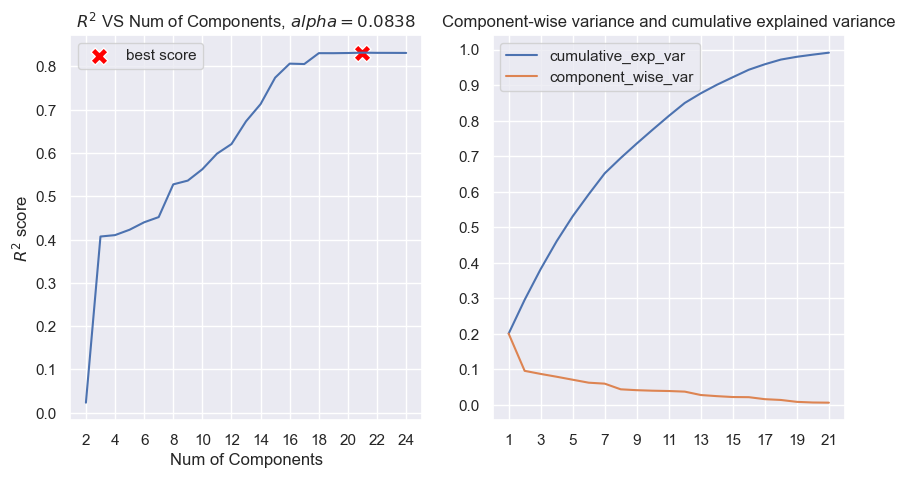

In [41]:
scores = results.groupby('param_pca__n_components').max()['mean_test_score']

fig, axs = plt.subplots(ncols=2, figsize=(10,5))

sns.lineplot(y=scores, x=scores.index, ax=axs[0])
sns.scatterplot([best_ncomponents], [search.best_score_], 
                color='red', s=150, marker='X', 
                ax=axs[0], label='best score')

xs = range(1, best_ncomponents+1)
sns.lineplot(y=cumsum_evr, x=xs, label='cumulative_exp_var', ax=axs[1])
sns.lineplot(y=best['pca'].explained_variance_ratio_, x=xs, label='component_wise_var', ax=axs[1])

axs[0].set_title(f'$R^2$ VS Num of Components, $alpha={round(best_alpha,4)}$')
axs[0].set_ylabel('$R^2$ score')
axs[0].set_xlabel('Num of Components')
axs[0].set_xticks(range(min_components, max_components,2))
axs[1].set_title('Component-wise variance and cumulative explained variance')
axs[1].set_yticks(np.arange(0,1.1,.1))
axs[1].set_xticks(range(1, best_ncomponents+1,2))
axs[1].set_ylabel('')
axs[1].set_xlabel('')

fig.show()

Our components can explain 99.11% of the variance with 21 components instead 25. According to left and right graphs, we can continue reducing dimension to 18 with fixed alpha and getting the same score.

In [42]:
pca = PCA(best_ncomponents)
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train_valuable)
X_train_pca = pca.fit_transform(X_train_valuable)
X_train_pca = pd.DataFrame(columns=[f'PCA {i+1}' for i in range(X_train_pca.shape[1])], data=X_train_pca)
X_train_pca.head()

PCA 1          PCA 2         PCA 3        PCA 4        PCA 5  \
0  284229.591597  -82967.451045  -2907.659742  4071.747131 -3001.384968   
1   91706.189290  282772.995270   8492.710246  2465.734659  1388.840403   
2 -261067.847102   23509.410922 -12259.580586 -7202.911650 -1539.382186   
3  -20791.532886  -19835.047842  -2824.205501 -4600.098197  3954.775710   
4  -20464.230048  -27910.682063   2384.385006  6326.787027  5047.485172   

         PCA 6      PCA 7     PCA 8     PCA 9    PCA 10  ...    PCA 12  \
0   361.368823 -10.800078 -2.008266 -0.590414 -2.939858  ...  0.713498   
1   347.065618 -68.241889  2.193607  7.548573 -8.223157  ...  0.667454   
2   635.764133 -38.273729 -5.686008 -0.935493 -2.741511  ... -0.206742   
3 -1552.075814 -43.739557 -2.000779  2.575705  5.255207  ...  0.803882   
4  1790.462223   1.285779  0.361993  1.069237  5.906880  ... -0.303035   

     PCA 13    PCA 14    PCA 15    PCA 16    PCA 17    PCA 18    PCA 19  \
0 -0.435041 -0.076498 -0.177265  0.129982 -0.000442 -0.016128  0.045056   
1 -0.781544  0.228266  0.029079  0.120355 -0.053481  0.226333  0.094574   
2 -0.145960  0.120350  0.137409 -0.243228  0.099866  0.077721 -0.111764   
3  0.566326 -0.221655 -0.133398  0.208356 -0.161258 -0.001982 -0.036087   
4  0.849655 -0.067455 -0.210049  0.219441 -0.100208  0.041205 -0.059080   

     PCA 20    PCA 21  
0  0.008901 -0.044548  
1 -0.009146 -0.024722  
2  0.066007 -0.067198  
3 -0.024826 -0.030562  
4  0.071322  0.013552  

[5 rows x 21 columns]

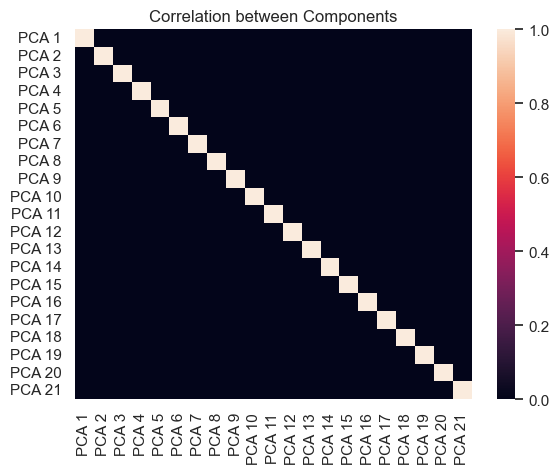

In [43]:
corrs = X_train_pca.corr()
sns.heatmap(corrs)
plt.title('Correlation between Components')
plt.show()

In [44]:
preds = cross_val_predict(best, X_train_valuable, y_train, cv=5)
lpca_r2 = r2_score(y_train, preds)
lpca_rmse = np.sqrt(mean_squared_error(y_train, preds))
print('CV R2 score:', lpca_r2)
print('CV RMSE score:', lpca_rmse)

CV R2 score: 0.8340731600448864
CV RMSE score: 25.668385540018967


## Selecting the best model

In [45]:
results = pd.DataFrame({'R2': [l_r2, r_r2 , e_r2, lpca_r2],
                       'RMSE': [l_rmse, r_rmse, e_rmse, lpca_rmse]}, 
                       index=['Lasso', 'Ridge', 'ElasticNet', 'Lasso (PCA)'])
display(results)

R2       RMSE
Lasso        0.824388  26.231698
Ridge        0.818454  26.690128
ElasticNet   0.824413  26.230434
Lasso (PCA)  0.834073  25.668386

$R^2$ and ***RMSE*** were calculated with cross validation so model shouldn't be overfitted. According to the results **the best model is Lasso (with PCA decomposition)** but all our models have similar results.

So we'll choose a model which have less number of features.

- we remember that ElasticNet have $l1-ratio = 1.0$ and almost the same $\alpha$ as Lasso's one. 
- ridge regression always have more features than Lasso

That's why it'll be enough for us to compare Lasso and Lasso PCA.

Lasso PCA model requires 21 features vs 24 ones for Lasso. Moreover these features aren't correlated with each other, that's why we deffinitely won't have multicollinearity. 

Anyway we got the most valuable features. **There are 24 of them out of 85**

In [46]:
fig = px.bar(x=valuable_columns, y=valuable_weights)
fig.update_layout(title_text='Valuable features of Lasso Regression')
fig.show()

<b><p style='color: red'>PLOTLY CAN'T BE DISPLAYED ON GITHUB JUPITER, SO HERE'S .png IMAGE OF THE GRAPH</p></b>

<img src='https://github.com/ssensse/ds_labs/blob/main/CreditScore_Regression/PlotlyGraphs/valuableFeatures_Lasso.png?raw=true'>

We don't need all of 85 features but 24. And these 24 columns we turn into 21 with PCA and get a better model. 

Our adjusted `Pipeline` can both standardize the data and apply the PCA and predict the test data.

In [47]:
best

Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA(n_components=21)),
                ('model', Lasso(alpha=0.08376776400682924))])

## Testing the best model

R2: 0.8001014232064798
RMSE: 28.18672675160035


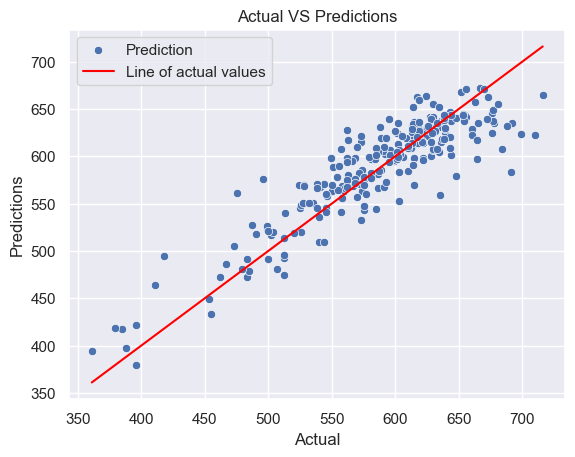

In [49]:
X_test = X_test[valuable_columns]
preds = best.predict(X_test)

print('R2:', r2_score(y_test, preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, preds)))

sns.scatterplot(y=preds, x=y_test, label='Prediction')
sns.lineplot(y=y_test, x=y_test, color='red', label='Line of actual values')
plt.ylabel('Predictions')
plt.xlabel('Actual')
plt.title('Actual VS Predictions')
plt.show()